In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3

import pandas as pd

prefix = "binaryoptimization/maxcut"
# prefix = "discreteoptimization/tsp"
# prefix = "binaryoptimization/max3sat/satlib"

clauses = [
    f"`hid` LIKE '{prefix}%'",
    "`trotterization` = 'suzuki_trotter'",
    "`n_timesteps` = 1",
    "`order` = 4",
    "`n_qubits` >= 8",
    "`n_qubits` <= 127",
    "`n_terms` >= 10",
    "`n_terms` <= 1000",
]
query = "SELECT * FROM `results` WHERE " + " AND ".join(clauses)

with sqlite3.connect("out/reordering/results.db") as db:
    df = pd.read_sql(query, db)

df.dropna(inplace=True)
df["time"] = df["reordering_time"] + df["synthesis_time"]
df.drop(["reordering_time", "synthesis_time"], axis=1, inplace=True)

# one how per (hid, method)
df = df.loc[df.groupby(["hid", "method"])["depth"].idxmin()]

df["problem_group"] = df["hid"].map(lambda hid: "/".join(hid.split("/")[:3]))
df = df.astype(
    {"n_terms": int, "depth": int, "n_timesteps": int, "order": int, "n_qubits": int}
)

df

,hid,method,n_terms,n_qubits,n_timesteps,order,trotterization,depth,jid,time,problem_group
59952,binaryoptimization/maxcut/biqmac/ising-hams/1-...,misra_gries,45,82,1,4,suzuki_trotter,90,248a7fda947c4026ed507fc431d8becc720d761d,7.361,binaryoptimization/maxcut/biqmac
44757,binaryoptimization/maxcut/biqmac/ising-hams/1-...,none,45,82,1,4,suzuki_trotter,165,4061e18979acfdf86fbd365cbb2f269fdf0ea8bd,3.659,binaryoptimization/maxcut/biqmac
90115,binaryoptimization/maxcut/biqmac/ising-hams/1-...,saturation,45,82,1,4,suzuki_trotter,90,de3cc668731412233824ca01a63bbef00d2e26c7,6.208,binaryoptimization/maxcut/biqmac
919,binaryoptimization/maxcut/biqmac/ising-hams/1-...,misra_gries,66,93,1,4,suzuki_trotter,110,56314b5b606f1d8ed6ff6b3d7c6546e4a7370044,17.809,binaryoptimization/maxcut/biqmac
192663,binaryoptimization/maxcut/biqmac/ising-hams/1-...,none,66,93,1,4,suzuki_trotter,205,1f0308571f35b022de7e33f4259d82bb43423219,4.776,binaryoptimization/maxcut/biqmac
...,...,...,...,...,...,...,...,...,...,...,...
54794,binaryoptimization/maxcut/random/ham-graph-sta...,none,79,80,1,4,suzuki_trotter,785,57c26e50811ce64210bd35e78f01e73d1de41c5c,8.656,binaryoptimization/maxcut/random
19040,binaryoptimization/maxcut/random/ham-graph-sta...,saturation,79,80,1,4,suzuki_trotter,785,dfa38d5f0be029bbd60d487c4d007c5cee8957ab,9.997,binaryoptimization/maxcut/random
125913,binaryoptimization/maxcut/random/ham-graph-sta...,misra_gries,89,90,1,4,suzuki_trotter,885,1ece4407725e935f94b6988b4184cd82ed7546ab,239.437,binaryoptimization/maxcut/random
118029,binaryoptimization/maxcut/random/ham-graph-sta...,none,89,90,1,4,suzuki_trotter,885,992a18025af865a0e7142ced40c889db230e93e1,6.250,binaryoptimization/maxcut/random


In [3]:
# Add the time_pc and depth_pc colunms

dfp, lst = df.pivot(index="hid", columns="method"), []

for m in df["method"].unique():
    depth_pc = dfp["depth"][m] * 100 / (dfp["depth"]["none"] + 1e-3)
    time_pc = dfp["time"][m] * 100 / (dfp["time"]["none"] + 1e-3)
    lst.append(pd.DataFrame({"method": m, "depth_pc": depth_pc, "time_pc": time_pc}))

a = pd.concat(lst)
a = a.pivot(columns="method")
df = dfp.join(a).stack(future_stack=True).reset_index()

In [4]:
# Filter and remove outliers

from scipy.stats import zscore
import numpy as np

MAX_ZSCORE = 3

x = df[["time", "n_terms", "depth", "time_pc"]].to_numpy()
p = (np.abs(zscore(x)) < MAX_ZSCORE).all(axis=1)
print("Dropping", len(df) - p.sum(), "rows")
df = df[p]
print("Left:   ", len(df))

Dropping 6937 rows
Left:    102449


In [5]:
def _print_col_stats(msg: str, s: pd.Series):
    a, b, c, d = s.min(), s.mean(), s.std(), s.max()
    a, b, c, d = a.round(2), b.round(2), c.round(2), d.round(2)
    print(f"{msg}: {a} / {b} ({c}) / {d}")


print("Unique Hamiltonians:", len(df["hid"].unique()))
d = df[df["method"] == "none"].groupby("hid").first().reset_index()
_print_col_stats("n_qubits", d["n_qubits"])
_print_col_stats("n_terms", d["n_terms"])
_print_col_stats("depth", d["depth"])

print("--------------------------------------------------")

for method in df["method"].unique():
    if method == "none":
        continue
    print("Method:", method)
    d = df[df["method"] == method]
    _print_col_stats("    Time %", d["time_pc"])
    _print_col_stats("    Depth %", d["depth_pc"])

print("--------------------------------------------------")

print("Unique problem groups:")
for pg in df["problem_group"].unique():
    print("   ", pg)

Unique Hamiltonians: 35512
n_qubits: 8 / 79.23 (26.54) / 127
n_terms: 10 / 134.68 (140.11) / 809
depth: 30 / 260.06 (176.55) / 705
--------------------------------------------------
Method: misra_gries
    Time %: 4.07 / 255.99 (148.88) / 868.56
    Depth %: 2.11 / 53.19 (13.02) / 114.28
Method: saturation
    Time %: 2.88 / 194.67 (99.23) / 866.17
    Depth %: 1.69 / 49.99 (11.74) / 100.0
--------------------------------------------------
Unique problem groups:
    binaryoptimization/maxcut/biqmac
    binaryoptimization/maxcut/ciqube
    binaryoptimization/maxcut/random


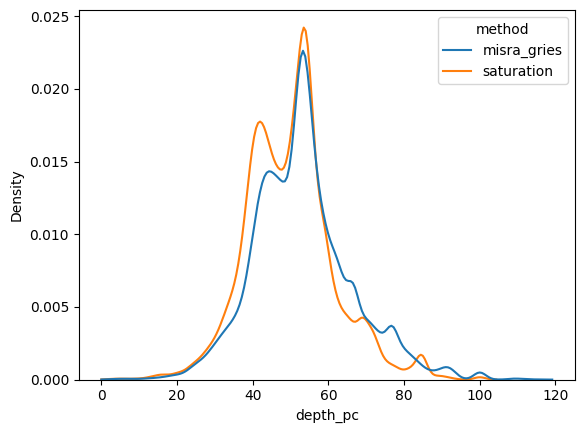

In [6]:
import seaborn as sns

_df = df[df["method"] != "none"]
ax = sns.kdeplot(data=_df, x="depth_pc", hue="method", clip=(0, None))

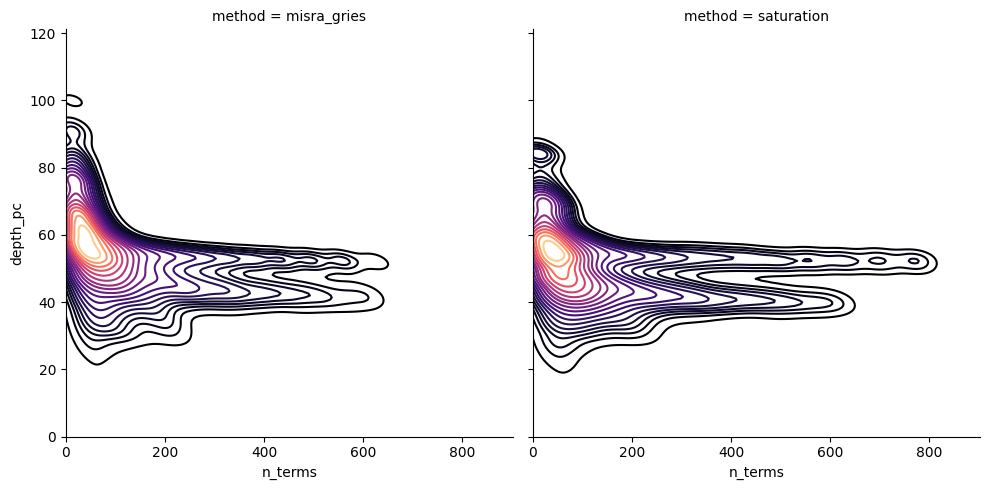

In [7]:
import seaborn as sns

_df = df[df["method"] != "none"]
ax = sns.displot(
    data=_df,
    x="n_terms",
    y="depth_pc",
    col="method",
    kind="kde",
    cmap="magma",
    levels=20,
    clip=((0, None), (0, None)),
)

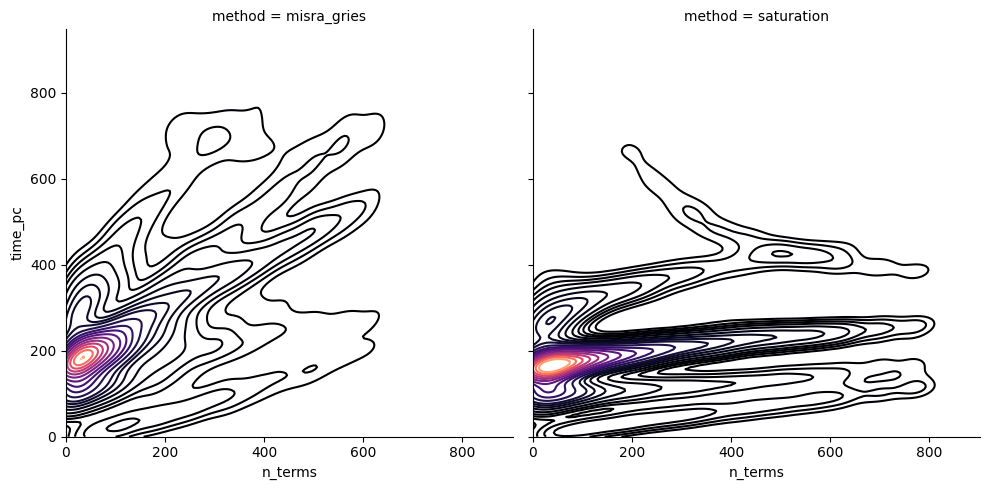

In [8]:
import seaborn as sns

_df = df[df["method"] != "none"]
ax = sns.displot(
    data=_df,
    x="n_terms",
    y="time_pc",
    col="method",
    kind="kde",
    cmap="magma",
    levels=20,
    clip=((0, None), (0, None)),
)